# BSU Foundation Analysis

In [1]:
#Import Python packages
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt

## Import & Clean Data

In [2]:
#Import Updated Gift Data
gift_df = pd.read_csv('Donor Loyalty Project Gift Detail UPDATED 3-18-22.csv', engine = "python")

In [3]:
#Add new column to display Year wihin Gift Data
gift_df['Gift Date']=pd.to_datetime(gift_df['Gift Date'])
gift_df['Gift Year']=gift_df['Gift Date'].dt.year
gift_df.head(3)

,Gift Date,Gift Amount,Gift Type,Soft Credit/Matching Gift Flag,Import ID,System Record ID,Fund ID,Fund Description,Fund Amount,Fund ID_1,...,Fund ID_2,Fund Description_2,Fund Amount_2,Fund ID_3,Fund Description_3,Fund Amount_3,Fund ID_4,Fund Description_4,Fund Amount_4,Gift Year
0,2012-09-24,$50.00,MG Pay-Cash,Soft Credit Recipient,93578,60806,000010F,The Ball State Fund,$50.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
1,2012-09-24,$50.00,MG Pledge,Soft Credit Recipient,93578,60806,000010F,The Ball State Fund,$50.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
2,2014-04-03,$100.00,MG Pledge,Soft Credit Recipient,333458,249510,094010F,WIPB-TV,$100.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014


In [4]:
#Dealing with the Dollar Signs & Transforming the Data Types
columns_to_change = gift_df.columns[gift_df.columns.str.contains("Amount")] 
gift_df[columns_to_change] = gift_df[columns_to_change].replace({r"\$": "", r"\,":""}, regex = True)

dtypes_to_change = ["Gift Amount", "Fund Amount", "Fund Amount_1",
                   "Fund Amount_2", "Fund Amount_3", 
                   "Fund Amount_4"]
gift_df[dtypes_to_change] = gift_df[dtypes_to_change].astype(float)
gift_df['Gift Date'] = pd.to_datetime(gift_df['Gift Date'])

In [5]:
#Import Donor Loyalty Project Education.xlsx with "Class Year of" column from excel (turned '90 in to 1990, etc.)
edu_df = pd.read_excel('Donor Loyalty Project Education-Years.xlsx')
edu_df['Class Year of'] = edu_df['Class Year of'].astype(str).apply(lambda x: x.replace('.0',''))
edu_df.head(3)

,Import ID,System Record ID,School Name,College,Department,Degree,Class of,Class Year of,Greek Affiliation,Major,...,Student Activity_35,Student Activity_36,Student Activity_37,Student Activity_38,Student Activity_39,Student Athlete_15,Student Athlete_16,Student Athlete_17,Student Athlete_18,Student Athlete_19
0,132479,93620,Ball State University,CSH College of Sciences & Humanities,Dept of Political Science,AA,'88,1988,NaN,517002 - Legal Assistance,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,132691,93805,Ball State University,TC Teachers College,Dept of Educational Leadership,MA,'08,2008,NaN,605001 - Adult & Community Education,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,133466,93866,Ball State University,TC Teachers College,Dept of Educational Leadership,MAE,'07,2007,NaN,603001 - Educational Admin & Suprvsn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Import Donor Loyalty Project Membership file with "Year Joined" (=YEAR(Date Joined) column in excel)
memb_df = pd.read_excel('Donor Loyalty Project Membership.xlsx')
memb_df['Date Joined']=pd.to_datetime(memb_df['Date Joined'])
memb_df['Year Joined']=memb_df['Date Joined'].dt.year
memb_df.head(3)

,Import ID,System Record ID,Membership Category,Date Joined,Consecutive Years,Last Renewed Date,Last Dropped Date,Expires On Date,Year Joined
0,132479,93620,Leaders and Loyals,2015-09-17,6,2021-07-02,NaN,2022-06-30,2015
1,132691,93805,Leaders and Loyals,2015-09-17,6,2021-07-02,NaN,2022-06-30,2015
2,133466,93866,Leaders and Loyals,2015-09-17,6,2021-07-20,NaN,2022-06-30,2015


In [7]:
#Import Donor Loyalty Project Biographical file
bio_df = pd.read_excel('Donor Loyalty Project Biographical.xlsx')
bio_df.head(3)

,Import ID,System Record ID,Age,DOB,Gender,Martial Status,Deceased?,No Valid Address?,Inactive?,Constituent Code,...,Constituent Code_3,Preferred City,Preferred State,Have Email in Database,Have Phone in Database,Spouse is a Constituent,No Email Restriction,No Solicitation Restriction,No Phone Solicitation Resctriction,Permanent No Contact
0,00001-593-0000728218,728218,NaN,NaN,Female,Married,NaN,NaN,NaN,Employee,...,NaN,Muncie,IN,yes,no,Yes,NaN,NaN,NaN,NaN
1,112564,76191,65.0,1956-07-07 00:00:00,Female,Divorced,NaN,NaN,NaN,Alumni,...,NaN,Muncie,IN,yes,yes,NaN,NaN,NaN,NaN,NaN
2,00001-593-0000742499,742499,NaN,NaN,Female,NaN,NaN,NaN,NaN,Radio/TV Donor,...,NaN,Muncie,IN,yes,yes,NaN,NaN,NaN,NaN,NaN


## Create Loyals Data Set

Loyals = 2 or more years, in a row, of giving (consecutive >=1)

In [8]:
#Filter for loyals
loyals = memb_df[memb_df['Consecutive Years']>=1]

#Create Column with just loyal description
loyals['Loyals']='Loyals'
loyals.head(3)

C:\Users\KALI~1.ODE\AppData\Local\Temp/ipykernel_1936/4097562132.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loyals['Loyals']='Loyals'


,Import ID,System Record ID,Membership Category,Date Joined,Consecutive Years,Last Renewed Date,Last Dropped Date,Expires On Date,Year Joined,Loyals
0,132479,93620,Leaders and Loyals,2015-09-17,6,2021-07-02,NaN,2022-06-30,2015,Loyals
1,132691,93805,Leaders and Loyals,2015-09-17,6,2021-07-02,NaN,2022-06-30,2015,Loyals
2,133466,93866,Leaders and Loyals,2015-09-17,6,2021-07-20,NaN,2022-06-30,2015,Loyals


In [9]:
#check duplicates
memb_df.duplicated(subset=['System Record ID']).sum()

0

Total Number of Loyals (since we show 0 duplicate System Record IDs)

In [10]:
loyals.shape[0]

22389

## Create Leaders Data Set

A leader being a donor who has given $1000 or more, within one fiscal year

In [11]:
#drop unnecessary columns, as we want just Leader information right now
leaders = gift_df.drop(columns=["Gift Type","Soft Credit/Matching Gift Flag",
                                       "Fund Amount", "Fund Amount_1", "Fund ID", "Fund Description",
                                       "Fund Amount_2", "Fund Amount_3", "Fund Amount_4",
                                      "Fund ID_1", "Fund Description_1","Fund ID_2", "Fund Description_2",
                                      "Fund ID_3", "Fund Description_3", "Fund ID_4", "Fund Description_4"])
leaders.head(3)

,Gift Date,Gift Amount,Import ID,System Record ID,Gift Year
0,2012-09-24,50.0,93578,60806,2012
1,2012-09-24,50.0,93578,60806,2012
2,2014-04-03,100.0,333458,249510,2014


In [12]:
#Create new column to determine fiscal year based on gift date. Donoations start back in 2011
leaders['Fiscal Year']=np.where((leaders['Gift Date']>='7/01/2011') & (leaders['Gift Date']<='6/30/2012'), 'FY 2012',
                            np.where((leaders['Gift Date']>='7/01/2012') & (leaders['Gift Date']<='6/30/2013'), 'FY 2013',
                            np.where((leaders['Gift Date']>='7/01/2013') & (leaders['Gift Date']<='6/30/2014'), 'FY 2014',
                            np.where((leaders['Gift Date']>='7/01/2014') & (leaders['Gift Date']<='6/30/2015'), 'FY 2015',
                                np.where((leaders['Gift Date']>='7/01/2015') & (leaders['Gift Date']<='6/30/2016'), 'FY 2016',
                                    np.where((leaders['Gift Date']>='7/01/2016') & (leaders['Gift Date']<='6/30/2017'), 'FY 2017',
                                        np.where((leaders['Gift Date']>='7/01/2017') & (leaders['Gift Date']<='6/30/2018'), 'FY 2018',
                                            np.where((leaders['Gift Date']>='7/01/2018') & (leaders['Gift Date']<='6/30/2019'), 'FY 2019',
                                                np.where((leaders['Gift Date']>='7/01/2019') & (leaders['Gift Date']<='6/30/2020'), 'FY 2020',
                                                    np.where((leaders['Gift Date']>='7/01/2020') & (leaders['Gift Date']<='6/30/2021'), 'FY 2021',
                                                        np.where((leaders['Gift Date']>='7/01/2021') & (leaders['Gift Date']<='6/30/2022'), 'FY 2022',
                                                 'Other')))))))))))
leaders.head(3)

,Gift Date,Gift Amount,Import ID,System Record ID,Gift Year,Fiscal Year
0,2012-09-24,50.0,93578,60806,2012,FY 2013
1,2012-09-24,50.0,93578,60806,2012,FY 2013
2,2014-04-03,100.0,333458,249510,2014,FY 2014


In [13]:
#Group Data to determine Donors that gave at least, $1K+ within one fiscal year.
leaders_grp =leaders.groupby(['System Record ID','Fiscal Year']).agg({'Gift Amount':sum})
leaders_grp

Gift Amount
System Record ID Fiscal Year             
20               FY 2012           100.00
                 FY 2013           105.00
                 FY 2014            40.00
                 FY 2015            39.76
                 FY 2016            70.00
...                                   ...
763595           FY 2022          7500.00
763603           FY 2022           150.00
763725           FY 2022         50000.00
763750           FY 2022          1000.00
764031           FY 2022           800.00

[196126 rows x 1 columns]

In [14]:
#Filter for gift amount with grp'd data
leaders_fnl = leaders_grp[leaders_grp['Gift Amount'] >= 1000]
leaders_fnl.shape[0]

20013

In [15]:
# drop duplicate values so that we can have a single file of leaders
leaders = leaders_fnl.reset_index().drop_duplicates(subset ='System Record ID', keep = 'first').set_index('System Record ID')
leaders.head(3)

,Fiscal Year,Gift Amount
System Record ID,,
29,FY 2012,1325.0
115,FY 2012,10250.0
118,FY 2012,2174.0


In [16]:
# we know expected value since we checked shape 26095-21716=4379
leaders.shape[0]

5415

In [17]:
#Create Leaders description for analysis
leaders['Leaders']='Leaders'
leaders.head(3)

,Fiscal Year,Gift Amount,Leaders
System Record ID,,,
29,FY 2012,1325.0,Leaders
115,FY 2012,10250.0,Leaders
118,FY 2012,2174.0,Leaders


### Create Master Data Set for Loyals, Leads, or Both

In [18]:
#outer join loyals with leaders so that we have all records (left, right, both)
loyal_leaders = pd.merge(loyals,leaders,on='System Record ID',how ='outer', indicator = True)
loyal_leaders.head(3)

,Import ID,System Record ID,Membership Category,Date Joined,Consecutive Years,Last Renewed Date,Last Dropped Date,Expires On Date,Year Joined,Loyals,Fiscal Year,Gift Amount,Leaders,_merge
0,132479,93620,Leaders and Loyals,2015-09-17,6.0,2021-07-02,NaN,2022-06-30,2015.0,Loyals,FY 2019,1017.11,Leaders,both
1,132691,93805,Leaders and Loyals,2015-09-17,6.0,2021-07-02,NaN,2022-06-30,2015.0,Loyals,FY 2012,1837.50,Leaders,both
2,133466,93866,Leaders and Loyals,2015-09-17,6.0,2021-07-20,NaN,2022-06-30,2015.0,Loyals,NaN,NaN,NaN,left_only


In [19]:
loyal_leaders.shape[0]

23740

In [20]:
#check duplicates
loyal_leaders.duplicated(subset=['System Record ID']).sum()

0

In [21]:
#Start to see how many are loyals (left), leaders(right), and loyal/leaders (both) from the merge
loyal_leaders['_merge'].value_counts()

left_only     18325
both           4064
right_only     1351
Name: _merge, dtype: int64

In [22]:
#Create a new column that has the correct description for the above

#First define mentod
def categorise(row):  
    if row['_merge'] == 'left_only':
        return 'Loyal'
    elif row['_merge'] == 'right_only':
        return 'Leader'
    return 'Both'

#Then apply
loyal_leaders['Designation'] = loyal_leaders.apply(lambda row: categorise(row), axis=1)
loyal_leaders.head(3)

,Import ID,System Record ID,Membership Category,Date Joined,Consecutive Years,Last Renewed Date,Last Dropped Date,Expires On Date,Year Joined,Loyals,Fiscal Year,Gift Amount,Leaders,_merge,Designation
0,132479,93620,Leaders and Loyals,2015-09-17,6.0,2021-07-02,NaN,2022-06-30,2015.0,Loyals,FY 2019,1017.11,Leaders,both,Both
1,132691,93805,Leaders and Loyals,2015-09-17,6.0,2021-07-02,NaN,2022-06-30,2015.0,Loyals,FY 2012,1837.50,Leaders,both,Both
2,133466,93866,Leaders and Loyals,2015-09-17,6.0,2021-07-20,NaN,2022-06-30,2015.0,Loyals,NaN,NaN,NaN,left_only,Loyal


In [23]:
#Let us confrim that our new variable output matches the merge output
loyal_leaders['Designation'].value_counts()

Loyal     18325
Both       4064
Leader     1351
Name: Designation, dtype: int64

In [24]:
#drop helper columns from final designation file
loyal_leaders_fnl = loyal_leaders.drop(columns=["Loyals","Leaders","_merge"])
loyal_leaders_fnl.head(3)

,Import ID,System Record ID,Membership Category,Date Joined,Consecutive Years,Last Renewed Date,Last Dropped Date,Expires On Date,Year Joined,Fiscal Year,Gift Amount,Designation
0,132479,93620,Leaders and Loyals,2015-09-17,6.0,2021-07-02,NaN,2022-06-30,2015.0,FY 2019,1017.11,Both
1,132691,93805,Leaders and Loyals,2015-09-17,6.0,2021-07-02,NaN,2022-06-30,2015.0,FY 2012,1837.50,Both
2,133466,93866,Leaders and Loyals,2015-09-17,6.0,2021-07-20,NaN,2022-06-30,2015.0,NaN,NaN,Loyal


Export Final to CSV

In [25]:
loyal_leaders.to_csv('Donor Loyalty Project Membership Designations.csv')

# Analysis Tasks

## Basic Analysis of Donations

**Top 15 designations by Donor Fund Description**

In [26]:
top_fund = gift_df['Fund Description'].value_counts(normalize = True).head(15)
top_fund

The Ball State Fund                                 0.148325
AA Alumni Association Funding                       0.143064
Indiana Public Radio                                0.122750
WIPB-TV                                             0.097530
Cardinal Excellence Fund                            0.048998
Teachers College Dean's Fund for Excellence         0.020719
Miller College of Business General                  0.017844
WIPB-TV QPQ Deduction                               0.012485
College of Sciences and Humanities                  0.010983
Student Scholarships                                0.009615
Theatre Scholarships                                0.008520
CF Martin Riverside Society Fund                    0.008246
Center for Information and Communication Science    0.007046
Parents Fund                                        0.006949
Football                                            0.006669
Name: Fund Description, dtype: float64

**Create Bar Chart**

<function matplotlib.pyplot.show(close=None, block=None)>

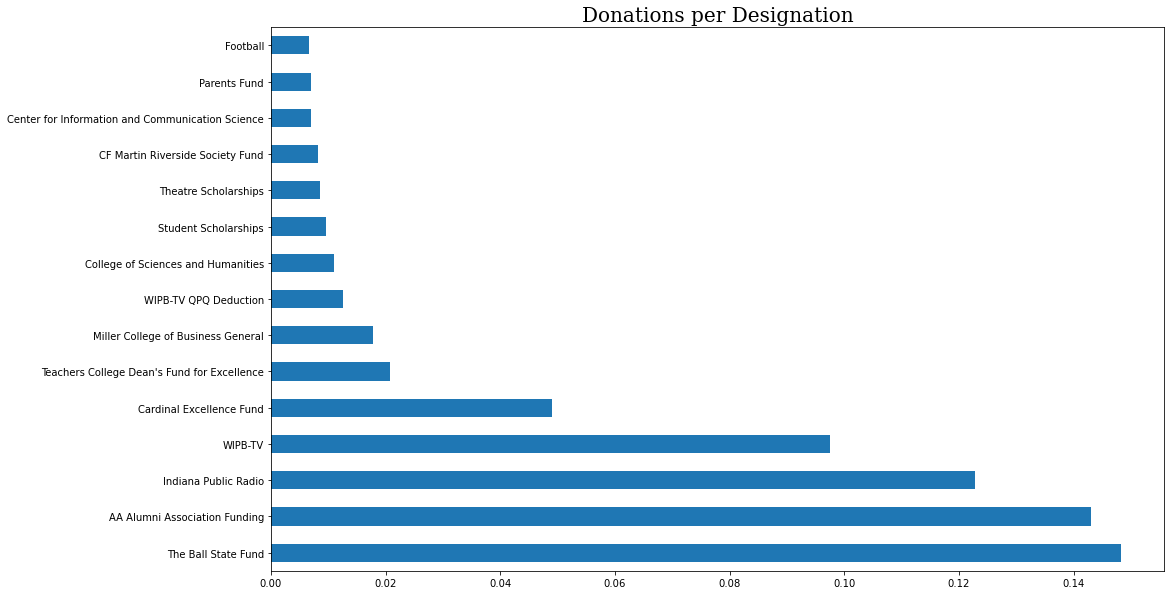

In [27]:
#create bar plot
plt.figure(figsize=(16, 10))
top_fund.plot.barh()
plt.title("Donations per Designation",font="Serif", size=20)
plt.show

In [28]:
#Top 15 designations by amount funded
desig_sum = gift_df.groupby(['Fund Description']).agg({'Fund Amount':sum}).sort_values('Fund Amount', ascending = False)
desig_sum.head(15)

,Fund Amount
Fund Description,
Indoor Turf Pavilion Fund,66321502.68
Restricted contributions,49023307.57
The Ball State Fund,17865290.86
Cardinal Commitment Campaign,12975086.34
Museum of Art Non-Cash Gifts,12810621.25
Cardinal Excellence Fund,10829679.85
Dr. Paul W. Parkison Fund for Accounting Excellence,8439849.13
Applied Behavior Analysis and Autism Programs,8359103.05
Grand Lawn Amphitheater Fund,7950000.00


In [29]:
#Top 15 median donations
desig_sum = gift_df.groupby(['Fund Description']).agg({'Fund Amount':'median'}).sort_values('Fund Amount', ascending = False)
desig_sum.head(15)

,Fund Amount
Fund Description,
Cardinal Connect Internship Endowment,1500000.000
Lilly Endowment Grant for Charting the Future (CTF) Initiative,1375000.000
Michelle A. and James T. Ryan Family Scholarship,1000000.000
George and Frances Ball Scholars Matching Gift Program,800000.000
ELI-Menard Family Fund,800000.000
Weidner Scholarship in Residential Property Management,790000.000
TeenWorks@BSU,773165.505
Grants Direct to BSU - Planetarium,500000.000
June E Everitt Endowment,500000.000


### Do different constituency groups provide more loyal donors or not?

In [30]:
#Merge original loyals data with biographical data
const = pd.merge(loyals, bio_df[['System Record ID','Import ID', 'Age', 'Gender', 'Martial Status', 'Constituent Code']], on='System Record ID')
const.shape

(22389, 15)

In [31]:
#Number of each constituency
const['Constituent Code'].value_counts()

Alumni                           14728
Friend                            3110
Alumni Spouse/Partner             1595
Radio/TV Donor                    1312
Corporation                        635
Non-Degreed Alumni                 259
Parent                             177
Trust of an Alumnus/a              156
Employee                            90
Indiana Academy                     77
Other Organization                  70
Trust of a Friend                   61
Foundation                          59
Student                             52
Burris                               7
Individual added by mail list        1
Name: Constituent Code, dtype: int64

In [32]:
p2 = const['Constituent Code'].value_counts(normalize = True)
p2

Alumni                           0.657823
Friend                           0.138907
Alumni Spouse/Partner            0.071240
Radio/TV Donor                   0.058600
Corporation                      0.028362
Non-Degreed Alumni               0.011568
Parent                           0.007906
Trust of an Alumnus/a            0.006968
Employee                         0.004020
Indiana Academy                  0.003439
Other Organization               0.003127
Trust of a Friend                0.002725
Foundation                       0.002635
Student                          0.002323
Burris                           0.000313
Individual added by mail list    0.000045
Name: Constituent Code, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

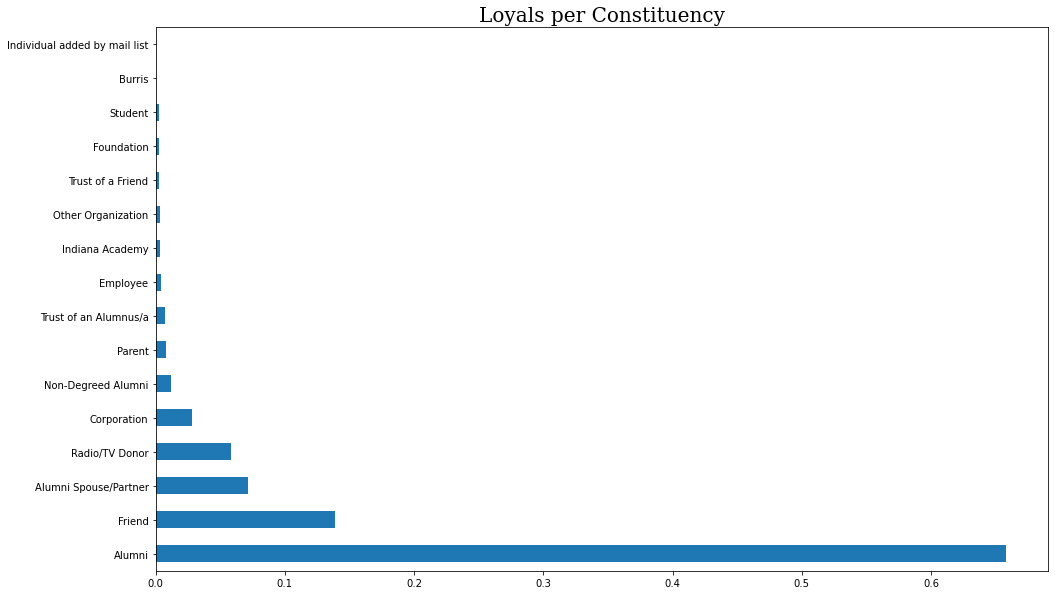

In [33]:
plt.figure(figsize=(16, 10))
p2.plot.barh()
plt.title("Loyals per Constituency",font="Serif", size=20)
plt.show

## Generational trends of donors

 - Rank generations based on total donations
 - Where each generation donates the most
 - Rank generations based on # of loyals

In [34]:
#Inner merge of gift_df and bio_df for the Generation Analysis
gift_bio = pd.merge(gift_df, bio_df, on='System Record ID', indicator = True)
gift_bio.head(3)

,Gift Date,Gift Amount,Gift Type,Soft Credit/Matching Gift Flag,Import ID_x,System Record ID,Fund ID,Fund Description,Fund Amount,Fund ID_1,...,Preferred City,Preferred State,Have Email in Database,Have Phone in Database,Spouse is a Constituent,No Email Restriction,No Solicitation Restriction,No Phone Solicitation Resctriction,Permanent No Contact,_merge
0,2012-09-24,50.0,MG Pay-Cash,Soft Credit Recipient,93578,60806,000010F,The Ball State Fund,50.0,NaN,...,Carmel,IN,yes,yes,NaN,NaN,NaN,NaN,NaN,both
1,2012-09-24,50.0,MG Pledge,Soft Credit Recipient,93578,60806,000010F,The Ball State Fund,50.0,NaN,...,Carmel,IN,yes,yes,NaN,NaN,NaN,NaN,NaN,both
2,2014-07-07,55.0,MG Pay-Cash,Soft Credit Recipient,93578,60806,012010F,Miller College of Business General,55.0,NaN,...,Carmel,IN,yes,yes,NaN,NaN,NaN,NaN,NaN,both


Create a "Generation" column based on donor's age

In [35]:
# conditions for each generation based on age
conditions = [
    (gift_bio['Age'] <= 10) & (gift_bio['Age'] <= 25),
    (gift_bio['Age'] >= 26) & (gift_bio['Age'] <= 41),
    (gift_bio['Age'] >= 42) & (gift_bio['Age'] <= 57),
    (gift_bio['Age'] >= 58) & (gift_bio['Age'] <= 76),
    (gift_bio['Age'] >= 77) & (gift_bio['Age'] <= 94)
    ]

# create a list of the values we want to assign for each condition
values = ['Gen Z', 'Millenial', 'Gen X', 'Boomer', 'Post War']

# create a new column and use np.select to assign values to it using our lists as arguments
gift_bio['Generation'] = np.select(conditions, values)

In [36]:
# only show main columns
gen_df = gift_bio.loc[:, ["System Record ID", "Gift Amount", "Fund Description", "Age","Generation"]]
gen_df.head(3)

,System Record ID,Gift Amount,Fund Description,Age,Generation
0,60806,50.0,The Ball State Fund,64.0,Boomer
1,60806,50.0,The Ball State Fund,64.0,Boomer
2,60806,55.0,Miller College of Business General,64.0,Boomer


### Generation based on donation amounts

In [37]:
# grouping by generation and sorting by highest gift amount
gen_final = gen_df.groupby('Generation').agg({'Gift Amount':sum})
gen_final.sort_values(by="Gift Amount",ascending=False)
# 0 indicates no age in data (important to see how many donations aren't connected to an age)

,Gift Amount
Generation,
0,2.136923e+08
Boomer,1.751251e+08
Post War,8.289368e+07
Gen X,3.555955e+07
Millenial,3.657636e+06
Gen Z,1.640077e+04


Text(0, 0.5, 'Gift Amount in Millions ($)')

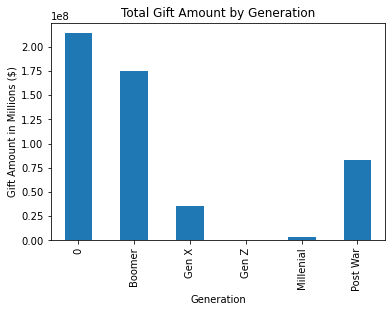

In [38]:
gen_final['Gift Amount'].plot.bar(title='Total Gift Amount by Generation').set_ylabel("Gift Amount in Millions ($)")

In [39]:
import matplotlib.pyplot as plt

<AxesSubplot:title={'center':'Gift Amount in Millions ($)'}, xlabel='Generation'>

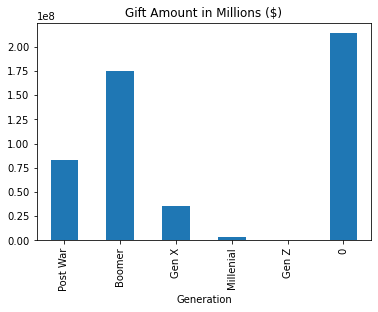

In [40]:
gen_order =["Post War","Boomer","Gen X","Millenial","Gen Z","0"]
gen_final['Gift Amount'].loc[gen_order].plot(kind="bar", legend=False, title='Gift Amount in Millions ($)')

**Total donations per generation (in dollars) (not reduced to loyals/leaders)**

- 213,692,300 - **0**
- 175,125,100 - **Boomers**
- 82,893,680 - **Post War**
- 35,559,550 - **Gen X**
- 3,657,636 - **Millenial**
- 16,400.77 - **Gen Z**

### Generation based on where they donate (Fund Description)

In [41]:
# removing 0 values since we're focusing on generations
gen_drop = gen_df[gen_df["Generation"] != '0']

# Grouping by generation and fund description to see which funds each generation donates the most to
gen_final = gen_drop.groupby(["Generation","Fund Description"]).agg({'Gift Amount':sum})
m = gen_final.sort_values(['Generation','Gift Amount'], ascending=[True, False])
#pd.set_option('display.max_rows', None) (use when wanting to double check top 3 for each generation)
#m (use when wanting to double check top 3 for each generation)
m.head(3)

Gift Amount
Generation Fund Description                      
Boomer     Indoor Turf Pavilion Fund  27260696.69
           Restricted contributions   25343006.12
           The Ball State Fund         7788270.13

### Top 3 Funds for each generation (in dollars):

*Boomer*
- 27,260,696.69 - Indoor Turf Pavillion Fund 
- 25,343,006.12 - Restricted Contributions 
- 7,788,270.13 - The Ball State Fund 

*Post War*
- 9,777,599.84 - Restricted Contributions 
- 8,968,020.75 - Museum of Art Non-Cash Gifts 
- 4,165,150.00 - June E Everitt Endowment

*Gen X*
- 8,435,960.00 - Indoor Turf Pavillion Fund 
- 4,476,350.00 - Restricted Contributions 
- 3,060,000.00 - Dobbs Family Fund 

*Millenial*
- 462,125.00 - AA Alumni Association Funding 
- 250,770.00 - Golf Practice Facility 
- 200,125.00 - Baseball/Softball Complex 

*Gen Z*
- 14,425.77 - Robert & Esther Cooper's "Science Student Award" 
- 855.00 - WIPB-TV 
- 677.00 - Hoops for Scholars 

### Generations based on # of loyals

In [42]:
# inner merge of merge2 table and loyals table
gen_loyals = pd.merge(gen_df, loyals, on='System Record ID', indicator = True)
gen_loyals.head(3)

,System Record ID,Gift Amount,Fund Description,Age,Generation,Import ID,Membership Category,Date Joined,Consecutive Years,Last Renewed Date,Last Dropped Date,Expires On Date,Year Joined,Loyals,_merge
0,60806,50.0,The Ball State Fund,64.0,Boomer,93578,Leaders and Loyals,2015-10-06,1,2017-06-26,NaN,2017-06-30,2015,Loyals,both
1,60806,50.0,The Ball State Fund,64.0,Boomer,93578,Leaders and Loyals,2015-10-06,1,2017-06-26,NaN,2017-06-30,2015,Loyals,both
2,60806,55.0,Miller College of Business General,64.0,Boomer,93578,Leaders and Loyals,2015-10-06,1,2017-06-26,NaN,2017-06-30,2015,Loyals,both


In [43]:
# show main columns for this question
gl_df = gen_loyals.loc[:, ["System Record ID", "Gift Amount", "Fund Description", "Age","Generation", "Membership Category", "Consecutive Years"]]
gl_df.head(3)

,System Record ID,Gift Amount,Fund Description,Age,Generation,Membership Category,Consecutive Years
0,60806,50.0,The Ball State Fund,64.0,Boomer,Leaders and Loyals,1
1,60806,50.0,The Ball State Fund,64.0,Boomer,Leaders and Loyals,1
2,60806,55.0,Miller College of Business General,64.0,Boomer,Leaders and Loyals,1


In [44]:
# drop duplicate record IDs to form a count of loyals
gl_df_nodups = gl_df.drop_duplicates(subset='System Record ID')
gl_df_nodups.head(3)

,System Record ID,Gift Amount,Fund Description,Age,Generation,Membership Category,Consecutive Years
0,60806,50.0,The Ball State Fund,64.0,Boomer,Leaders and Loyals,1
18,249510,100.0,WIPB-TV,65.0,Boomer,Leaders and Loyals,5
36,16094,100.0,Teachers College Dean's Fund for Excellence,71.0,Boomer,Leaders and Loyals,2


In [45]:
# rank generation by # of loyals
gl_df_count = gl_df_nodups.groupby(["Generation", 'Membership Category'])['Membership Category'].count()
gl_df_count.sort_values(ascending=False).head(6)
# 0 indicates no age associated with donor

Generation  Membership Category
Boomer      Leaders and Loyals     6471
0           Leaders and Loyals     6017
Gen X       Leaders and Loyals     3751
Post War    Leaders and Loyals     3187
Millenial   Leaders and Loyals     2939
Gen Z       Leaders and Loyals        1
Name: Membership Category, dtype: int64

Text(0, 0.5, 'Count of Loyals')

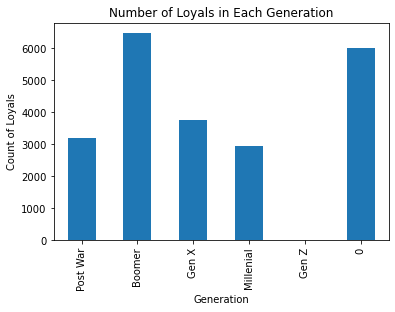

In [46]:
#add results into bar chart
gl_df_nodups.pivot_table(index=['Generation'],columns='Membership Category',aggfunc='size').loc[gen_order].plot(kind='bar', legend =False, title="Number of Loyals in Each Generation").set_ylabel("Count of Loyals")

### How long does it take from graduation for alumni to engage as loyal donors?

**Rank recent graduation years based on # of loyals**

In [47]:
#Inner merge of gift_df and educ_df to combine gift amount and class of donor
gift_edu = pd.merge(gift_df, edu_df, on='System Record ID', indicator = True)
# show main columns for this question
alum_edu = gift_edu.loc[:, ["System Record ID", "Gift Amount", "Fund Description","Class of", "Class Year of"]]
alum_edu.head(5)

,System Record ID,Gift Amount,Fund Description,Class of,Class Year of
0,60806,50.0,The Ball State Fund,'79,1979
1,60806,50.0,The Ball State Fund,'79,1979
2,60806,55.0,Miller College of Business General,'79,1979
3,60806,55.0,Miller College of Business General,'79,1979
4,60806,75.0,The Ball State Fund,'79,1979


In [48]:
#Inner merge of alum_edu and loyals to combine gift amount, class of donor, and loyal membership year joined
alum_edu_loyals = pd.merge(alum_edu, loyals, on='System Record ID', indicator = True)
# show main columns for this question
alum_edu_loyals2 = alum_edu_loyals.loc[:, ["System Record ID", "Gift Amount", "Fund Description","Class of", "Class Year of", "Date Joined", "Year Joined"]]
# remove duplicates and NA's to show count of loyals
alum_edu_loyals_nodups = alum_edu_loyals2.drop_duplicates(subset='System Record ID').dropna()
alum_edu_loyals_nodups.head(5)

,System Record ID,Gift Amount,Fund Description,Class of,Class Year of,Date Joined,Year Joined
0,60806,50.0,The Ball State Fund,'79,1979,2015-10-06,2015
36,16094,100.0,Teachers College Dean's Fund for Excellence,'73,1973,2018-03-15,2018
59,163736,500.0,The Ball State Fund,'98,1998,2015-11-18,2015
84,35343,50.0,Student Scholarships,'69,1969,2019-12-31,2019
576,64789,2500.0,Cardinal Excellence Fund,'80,1980,2015-09-17,2015


In [49]:
# making sure both columns are of int type to calculate difference between Year Joined and Class Year of donor
alum_edu_loyals_nodups['Class Year of'] = alum_edu_loyals_nodups['Class Year of'].astype(int)
alum_edu_loyals_nodups ['Year Joined'] = alum_edu_loyals_nodups['Year Joined'].astype(int)

In [50]:
# calculate years it took donors to become loyals from graduation year (scrap and use formula below?)
alum_edu_loyals_nodups["Years since graduation"] = alum_edu_loyals_nodups["Year Joined"] - alum_edu_loyals_nodups["Class Year of"]
# calculate years it took donors to become loyals from 2015 (launch year? - it was the oldest date on membership file)
alum_edu_loyals_nodups["Years since launch"] = alum_edu_loyals_nodups["Year Joined"] - 2015
alum_edu_loyals_nodups.head(5)

,System Record ID,Gift Amount,Fund Description,Class of,Class Year of,Date Joined,Year Joined,Years since graduation,Years since launch
0,60806,50.0,The Ball State Fund,'79,1979,2015-10-06,2015,36,0
36,16094,100.0,Teachers College Dean's Fund for Excellence,'73,1973,2018-03-15,2018,45,3
59,163736,500.0,The Ball State Fund,'98,1998,2015-11-18,2015,17,0
84,35343,50.0,Student Scholarships,'69,1969,2019-12-31,2019,50,4
576,64789,2500.0,Cardinal Excellence Fund,'80,1980,2015-09-17,2015,35,0


In [51]:
# group graduation year by average Years since launch
alum_edu_loyals_grp = alum_edu_loyals_nodups.groupby("Class Year of")['Years since launch'].mean()
alum_edu_loyals_grp.sort_values(ascending=True).head(10)
# for example, the average years it took donors in class of 1940 to become loyals was 0
# ie, many were probably already qualified for loyal membership when the program launched

Class Year of
1940    0.000000
1941    0.000000
1944    0.200000
1947    0.363636
1942    0.500000
1946    0.600000
1948    0.615385
1953    0.820513
1956    0.853333
1951    0.857143
Name: Years since launch, dtype: float64

In [52]:
# filter more recent graduation years (2010 and above)
alum_loyals_recent = alum_edu_loyals_nodups.loc[alum_edu_loyals_nodups['Class Year of']>=2010] 
alum_loyals_recent.head(5)

,System Record ID,Gift Amount,Fund Description,Class of,Class Year of,Date Joined,Year Joined,Years since graduation,Years since launch
1825,265389,25.0,Honors College,'14,2014,2016-07-29,2016,2,1
4687,264719,25.0,AA Alumni Association Funding,'14,2014,2015-09-17,2015,1,0
4802,239143,250.0,Center for Information and Communication Science,'10,2010,2017-06-26,2017,7,2
6449,236887,50.0,The Ball State Fund,'10,2010,2015-09-17,2015,5,0
16336,266592,10.0,Greater Indianapolis Alumni Chapter Scholarship,'14,2014,2017-06-26,2017,3,2


In [53]:
# group graduation year by average Years since launch
alum_loyals_recentg = alum_loyals_recent.groupby("Class Year of")['Years since launch'].mean()
alum_loyals_recentg.sort_values(ascending=True)
# ie, it takes about 1.87 years after the program launch for the class of 2010 to become loyal donors
# this is a more fair calculation for classes before 2015 (2015 is assumed launch year of program)

Class Year of
2010    1.872449
2011    2.014151
2013    2.125000
2012    2.188406
2014    2.301887
2015    2.881443
2016    3.200000
2017    3.493243
2020    3.738095
2019    3.818182
2018    3.887097
2021    3.952381
Name: Years since launch, dtype: float64

In [54]:
# group graduation year by average Years since graduation
alum_loyals_recentg = alum_loyals_recent.groupby("Class Year of")['Years since graduation'].mean()
alum_loyals_recentg.sort_values(ascending=True)
# ie, it takes about 1.49 years after graduation for the class of 2017 to become loyal donors
# this is a more fair calculation for classes after 2015

Class Year of
2021   -2.047619
2020   -1.261905
2019   -0.181818
2018    0.887097
2017    1.493243
2016    2.200000
2015    2.881443
2014    3.301887
2013    4.125000
2012    5.188406
2011    6.014151
2010    6.872449
Name: Years since graduation, dtype: float64

**It typically takes around 1 - 3 years after graduation for recent grads to become loyal donors. Based on the above data, 2018-2021 grads donated while they were still attending school therefore becoming loyal members before (or shortly after) graduating.**

More explaination of 2015 changing calculations:
- Graduate years before 2015 appear to have longer time before gaining loyal status if "Years since graduation" is used because they did not know about program before 2015 so I used "Years since launch".
- Graduate years after 2015 appear to have longer time before gaining loyal status if "Years since launch" is used because they weren't graduated yet and most likely hadn't started donating yet so I used "Years since graduation".

## Create Master Data Set for Upcoming Analysis

In [55]:
#Join edu_df with bio_df then check the number of records
bio_edu_df = pd.merge(edu_df, bio_df,on='System Record ID')
bio_edu_df.shape[0]

32552

In [56]:
#Left join loyal_leaders with bio_edu_df then check number of records
llb_df = pd.merge(loyal_leaders, bio_edu_df,on='System Record ID', how = 'left')
llb_df.shape[0]

23740

In [57]:
#Pull our columns for analysis and create master df
master = llb_df.loc[:, ["System Record ID", "College","Department", "Greek Affiliation","Leaders", "Loyals", "Designation", "Martial Status", "Gender","Class of"]]
master.head(3)

,System Record ID,College,Department,Greek Affiliation,Leaders,Loyals,Designation,Martial Status,Gender,Class of
0,93620,CSH College of Sciences & Humanities,Dept of Political Science,NaN,Leaders,Loyals,Both,Married,Female,'88
1,93805,TC Teachers College,Dept of Educational Leadership,NaN,Leaders,Loyals,Both,Divorced,Female,'08
2,93866,TC Teachers College,Dept of Educational Leadership,NaN,NaN,Loyals,Loyal,Married,Male,'07


## Donor Designation by Gender

In [58]:
llb_p = master.groupby(['Designation','Gender'])['College'].count().unstack('Gender')
llb_p

Gender,Female,Male,Unknown
Designation,,,
Both,1080,1270,0
Leader,179,231,0
Loyal,7069,5518,0


Plot Results via Charts

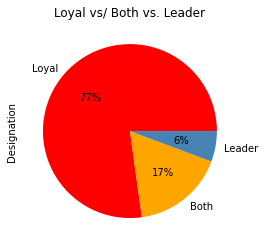

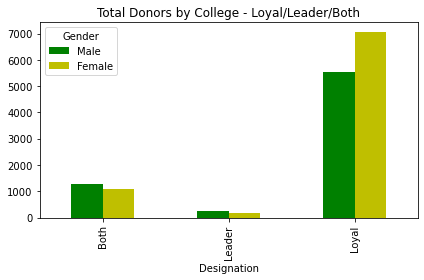

In [59]:
plot = master.Designation.value_counts().plot(kind='pie', autopct='%1.0f%%', colors = ['red', 'orange', 'steelblue'],title='Loyal vs/ Both vs. Leader')
plot_2 = llb_p [['Male','Female']].plot(kind='bar', stacked=False, title ='Total Donors by College - Loyal/Leader/Both', color =['g','y'])

plt.tight_layout()

## Donor Designation by Martial Status

In [60]:
llb_2 = master.groupby(['Designation','Martial Status']).size().unstack(fill_value=0)
llb_2

Martial Status,Divorced,Married,Partnered,Single,Widowed
Designation,,,,,
Both,142,2661,9,138,317
Leader,27,434,0,32,83
Loyal,702,11100,19,961,860


## Donors by Graduating Class

**Leader Donors by Class**

In [61]:
gl = master.groupby('Designation').get_group('Leader')
gl.groupby(['Designation', 'Class of'])['Class of'].count().nlargest(5).unstack('Designation').fillna(0)

Designation,Leader
Class of,
'64,11
'79,12
'80,12
'84,10
'90,13


**Loyal Donors by Class**

In [62]:
gl2 = master.groupby('Designation').get_group('Loyal')
gl2.groupby(['Designation', 'Class of'])['Class of'].count().nlargest(5).unstack('Designation').fillna(0)

Designation,Loyal
Class of,
'70,289
'71,274
'72,297
'73,337
'74,296


**Loyals & Leaders by Class**

In [63]:
gl3 = master.groupby('Designation').get_group('Both')
gl3.groupby(['Designation', 'Class of'])['Class of'].count().nlargest(5).unstack('Designation').fillna(0)

Designation,Both
Class of,
'69,78
'71,65
'72,70
'77,75
'80,68


## Donors by College

Designation,Both,Leader,Loyal,Total
College,,,,
MCOB Miller College of Business,716,92,2688,3496
CSH College of Sciences & Humanities,528,96,2839,3463
TC Teachers College,399,63,2680,3142
COH College of Health,253,44,1700,1997
"CCIM College of Communication, Information and Media",183,40,1008,1231
CFA College of Fine Arts,82,21,683,786
No College/Interdepartmental,100,27,657,784
CAP College of Architecture & Planning,89,27,332,448


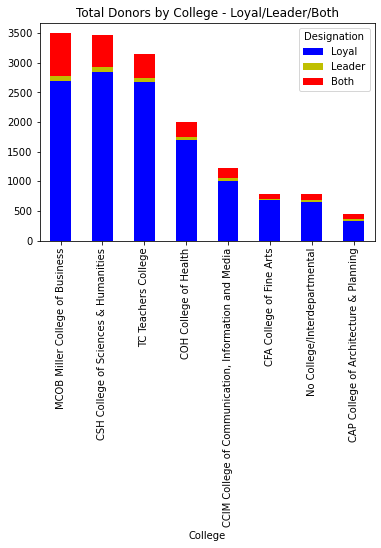

In [64]:
v_1 = master.groupby(['College', 'Designation'])['College'].count().unstack('Designation').fillna(0)
v_1['Total']= v_1['Both'] + v_1['Leader'] + v_1['Loyal']
v_1 = v_1.sort_values("Total", ascending = False)
v1 = v_1 [['Loyal','Leader','Both']].plot(kind='bar', stacked=True, title ='Total Donors by College - Loyal/Leader/Both', color =['b','y','r'])
v_1

### Donors by Departments in the Business College

In [65]:
A1 = master.groupby('College').get_group('MCOB Miller College of Business')
A1.groupby(['College','Department'])['Department'].count().nlargest(5).unstack('Department').fillna(0)

Department,College of Business,Dept of Accounting,Dept of Information Systems & Operations Mgt,Dept of Management,Dept of Marketing
College,,,,,
MCOB Miller College of Business,769,861,598,348,518


### Donors by Departments in the Science & Humanities College

In [66]:
A2 = master.groupby('College').get_group('CSH College of Sciences & Humanities')
A2.groupby(['College','Department'])['Department'].count().nlargest(5).unstack('Department').fillna(0)

Department,College of Sciences and Humanities,Dept of Biology,Dept of English,Dept of Mathematical Sciences,Dept of Psychological Science
College,,,,,
CSH College of Sciences & Humanities,544,401,458,341,257


### Donors by Departments in the Teachers College

In [67]:
A3 = master.groupby('College').get_group('TC Teachers College')
A3.groupby(['College','Department'])['Department'].count().nlargest(5).unstack('Department').fillna(0)

Department,Dept of Educational Leadership,Dept of Educational Studies,Dept of Elementary Education,Dept of Special Education,Family Consumer & Technology Education
College,,,,,
TC Teachers College,186,117,1885,233,620


## Donors by Greek Designation

In [68]:
k_1 = master.groupby(['Greek Affiliation', 'Designation'])['Greek Affiliation'].count().unstack('Designation').fillna(0)
k_1['Total'] = k_1['Both'] + k_1['Leader'] + k_1['Loyal']
k_1 = k_1.sort_values("Total", ascending = False)

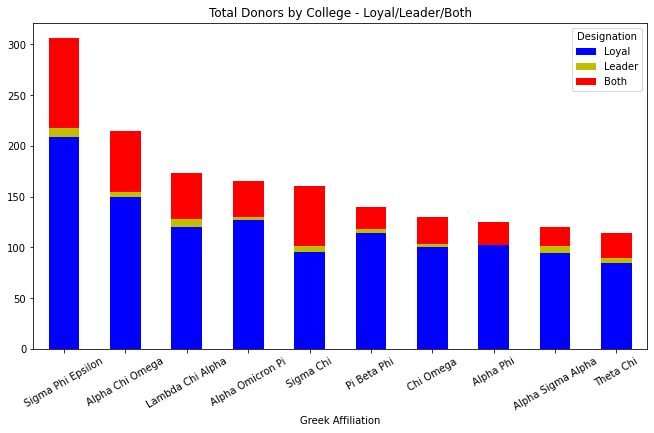

In [69]:
k_1_top = k_1.nlargest(10, ["Total"])
k2 = k_1_top [['Loyal','Leader','Both']].plot(kind='bar', stacked = True, title ='Total Donors by College - Loyal/Leader/Both', rot=30, color =['b','y','r'],figsize=(11,6))

## Donors in Sigma Phi Epsilon

**By College**

In [70]:
z1 = master.groupby('Greek Affiliation').get_group('Sigma Phi Epsilon')
z1.groupby(['College','Greek Affiliation'])['College'].count().nlargest(5).unstack('College').fillna(0)

College,"CCIM College of Communication, Information and Media",COH College of Health,CSH College of Sciences & Humanities,MCOB Miller College of Business,TC Teachers College
Greek Affiliation,,,,,
Sigma Phi Epsilon,13,60,80,101,30


**Top Five Donors By Class**

In [71]:
z1.groupby(['Class of','Greek Affiliation'])['Class of'].count().nlargest(5).unstack('Class of').fillna(0)

Class of,'59,'60,'61,'64,'67
Greek Affiliation,,,,,
Sigma Phi Epsilon,23,13,13,13,12


**Top 10 Donors by Class**

In [72]:
z1.groupby(['Class of','Greek Affiliation'])['Class of'].count().nlargest(10).unstack('Class of').fillna(0)

Class of,'58,'59,'60,'61,'63,'64,'67,'69,'70,'77
Greek Affiliation,,,,,,,,,,
Sigma Phi Epsilon,9,23,13,13,10,13,12,10,12,11
